In [1]:
import os
import glob
import cv2
import math
import itertools

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix

from sklearn import svm

In [2]:
class DriverDistractionHelper:
    
    def __init__(self, img_rows, img_cols, color_type=1):
        x_train, y_train, driver_id, unique_drivers = self.read_and_normalize_train_data(img_rows, img_cols, color_type)
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, shuffle=True)
        
        x_manual_tests = self.read_and_normalize_manual_test_data(120, 160, color_type)
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
        self.x_manual_tests = x_manual_tests
    
    def read_and_normalize_train_data(self, img_rows, img_cols, color_type):
        cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
        if not os.path.isfile(cache_path) or use_cache == 0:
            train_data, train_target, driver_id, unique_drivers = self.load_train(img_rows, img_cols, color_type)
            self.cache_data((train_data, train_target, driver_id, unique_drivers), cache_path)
        else:
            print('Restore train from cache!')
            (train_data, train_target, driver_id, unique_drivers) = restore_data(cache_path)

        train_data = np.array(train_data, dtype=np.uint8)
        train_target = np.array(train_target, dtype=np.uint8)
        train_data = train_data.reshape(train_data.shape[0], color_type*img_rows*img_cols)
        train_data = train_data.astype('float32')
        train_data /= 255
        print('Train shape:', train_data.shape)
        print(train_data.shape[0], 'train samples')
        return train_data, train_target, driver_id, unique_drivers
    
    def read_and_normalize_manual_test_data(self, img_rows, img_cols, color_type=1):
        cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
        if not os.path.isfile(cache_path) or use_cache == 0:
            test_data = self.load_manual_test(img_rows, img_cols, color_type)
            self.cache_data((test_data), cache_path)
        else:
            print('Restore test from cache!')
            (test_data, test_id) = restore_data(cache_path)

        test_data = np.array(test_data, dtype=np.uint8)
        test_data = test_data.reshape(test_data.shape[0], color_type*img_rows*img_cols)
        test_data = test_data.astype('float32')
        test_data /= 255
        print('Test shape:', test_data.shape)
        print(test_data.shape[0], 'test samples')
        return test_data
    
    def load_train(self, img_rows, img_cols, color_type=1):
        X_train = []
        y_train = []
        driver_id = []

        driver_data = self.get_driver_data()

        print('Read train images')
        for j in range(10):
            print('Load folder c{}'.format(j))
            path = os.path.join('..', 'input', 'train', 'c' + str(j), '*.jpg')
            files = glob.glob(path)
            for fl in files:
                flbase = os.path.basename(fl)
                img = self.get_image(fl, img_rows, img_cols, color_type)
                X_train.append(img)
                y_train.append(j)
                driver_id.append(driver_data[flbase])

        unique_drivers = sorted(list(set(driver_id)))
        print('Unique drivers: {}'.format(len(unique_drivers)))
        print(unique_drivers)
        return X_train, y_train, driver_id, unique_drivers
    
    def load_manual_test(self, img_rows, img_cols, color_type=1):
        print('Read manual test images')
        path = os.path.join('..', 'input', 'test', '*.jpg')
        files = glob.glob(path)
        X_test = []
        total = 0
        for fl in files:
            flbase = os.path.basename(fl)
            img = self.get_image(fl, img_rows, img_cols, color_type)
            X_test.append(img)
            total += 1
        return X_test
    
    def cache_data(self, data, path):
        if os.path.isdir(os.path.dirname(path)):
            file = open(path, 'wb')
            pickle.dump(data, file)
            file.close()
        else:
            print('Directory doesnt exists')
    
    def get_driver_data(self):
        dr = dict()
        path = os.path.join('..', 'input', 'driver_imgs_list.csv')
        print('Read drivers data')
        f = open(path, 'r')
        line = f.readline()
        while (1):
            line = f.readline()
            if line == '':
                break
            arr = line.strip().split(',')
            dr[arr[2]] = arr[0]
        f.close()
        return dr
    
    def get_image(self, path, img_rows, img_cols, color_type=1):
        # Load as grayscale
        if color_type == 1:
            img = cv2.imread(path, 0)
        elif color_type == 3:
            img = cv2.imread(path)
        return cv2.resize(img, (img_cols, img_rows))

In [3]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
img_rows = 48
img_cols = 64
color_type = 1

In [5]:
ddh = DriverDistractionHelper(img_rows, img_cols, color_type)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Directory doesnt exists
('Train shape:', (22424, 3072))
(22424, 'train samples')
Read manual test images
Directory doesnt exists
('Test shape:', (150, 19200))
(150, 'test samples')


In [6]:
clf = svm.SVC(gamma=0.001, C=100)

In [7]:
time_before = datetime.now()
clf.fit(ddh.x_train, ddh.y_train)
time_after = datetime.now()

In [8]:
training_time = time_after - time_before
training_time = training_time.total_seconds()

In [9]:
time_before = datetime.now()
predictions_valid = clf.predict(ddh.x_test)
time_after = datetime.now()

In [10]:
pred_time = time_after - time_before
pred_time_avg = (pred_time.total_seconds()*1000)/len(ddh.x_test)

In [11]:
y_comp = [1 if i==j else 0 for i,j in zip(predictions_valid, ddh.y_test)]

In [12]:
accuracy = np.mean(y_comp)

In [13]:
cm = confusion_matrix(predictions_valid, ddh.y_test)

In [14]:
print 'Accuracy: ', accuracy
print 'Training Time: ', training_time
print 'Average Time to Classify a Image: ', pred_time_avg

Accuracy:  0.995945945946
Training Time:  243.155061
Average Time to Classify a Image:  25.7092610811


In [15]:
classes = ['safe driving', 'texting - right', 'talking on the phone - right', 'exting - left', 'talking on the phone - left',
          'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
keys = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

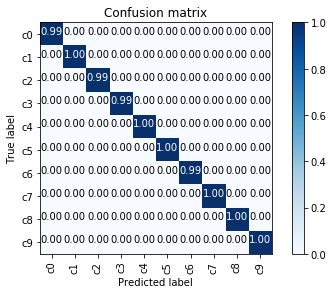

In [16]:
plot_confusion_matrix(cm, keys, normalize=True)

In [30]:
clf.score(ddh.x_test, ddh.y_test)

0.99594594594594599

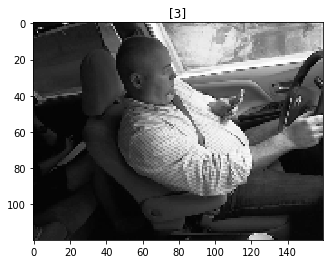

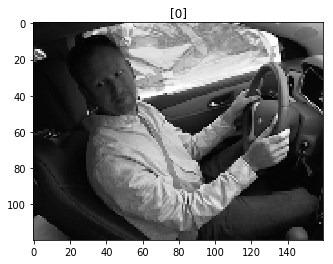

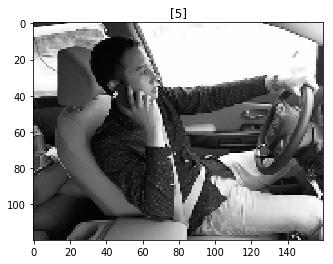

In [28]:
for i in range(3):
    img_brute = ddh.x_manual_tests[i]
    img = img_brute.reshape(120, 160, 1)
    img = cv2.resize(img, (img_cols, img_rows))
    img = img.reshape(img_rows*img_cols).reshape(1, -1)
    predicted = clf.predict(img)
        
    plt.figure()
    plt.title(predicted)
    plt.imshow(img_brute.reshape(120, 160), cmap='gray')

In [11]:
from sklearn.externals import joblib
joblib.dump(clf, 'svm_model.pkl')

['svm_model.pkl']